In [1]:
import numpy as np
import scipy.io
from sklearn import preprocessing
from sklearn import cross_validation
from sklearn import manifold
import matplotlib
import matplotlib.pyplot as plt
import numpy.linalg as lin
%matplotlib inline

In [2]:
fileidxJW11 = scipy.io.loadmat("/Users/corbinrosset/Dropbox/XRMB/DATA/FILEIDX/fileidxJW11.mat")
fileidxJW13 = scipy.io.loadmat("/Users/corbinrosset/Dropbox/XRMB/DATA/FILEIDX/fileidxJW13.mat")
fileidxJW24 = scipy.io.loadmat("/Users/corbinrosset/Dropbox/XRMB/DATA/FILEIDX/fileidxJW24.mat")
fileidxJW30 = scipy.io.loadmat("/Users/corbinrosset/Dropbox/XRMB/DATA/FILEIDX/fileidxJW30.mat")

JW11 = scipy.io.loadmat("/Users/corbinrosset/Dropbox/XRMB/DATA/MAT/JW11[numfr1=7,numfr2=7].mat")
JW13 = scipy.io.loadmat("/Users/corbinrosset/Dropbox/XRMB/DATA/MAT/JW13[numfr1=7,numfr2=7].mat")
JW24 = scipy.io.loadmat("/Users/corbinrosset/Dropbox/XRMB/DATA/MAT/JW24[numfr1=7,numfr2=7].mat")
JW30 = scipy.io.loadmat("/Users/corbinrosset/Dropbox/XRMB/DATA/MAT/JW30[numfr1=7,numfr2=7].mat")

In [34]:
#generate manageable 2d data

def generateData(numGaussians=3, numTraining=5000, numTesting=1000):
    #numGaussians = 5 #also the number of classes
    #N = 5000 #num training examples per class
    #T = 1000 #num testing examples per class
    gaussians = []
    test = []
    for i in range(numGaussians):
        mean = 10 * np.random.randn(2)
        cov = np.random.randint(10, size=(2, 2))
        x_train = np.random.multivariate_normal(mean, cov, N).T
        x_test = np.random.multivariate_normal(mean, cov, T).T
        plt.plot(x_train[0], x_train[1], 'x')
        gaussians.append(x_train) #train data
        test.append(x_test) #test data

    #format and plot the training data X, and test data X_test
    plt.axis('equal')
    plt.title('Training Data')
    plt.show()
    X_separated = np.array(gaussians) # shape #(3, 2, N) for 3 classes of N 2-D points each
    X = np.concatenate(X_separated, axis=1) #shape (2, 3*N)
    X_test = np.concatenate(test, axis = 1)
    X = X.T
    X_test = X_test.T

    #create data labels for training set X and test set X_test
    y, y_test = [], []
    for n in range(numGaussians):
        y = y + [n for i in range(N)]
        y_test = y_test + [n for i in range(T)]

    y = np.array(y)
    y_test = np.array(y_test)
    return X, X_test, y, y_test

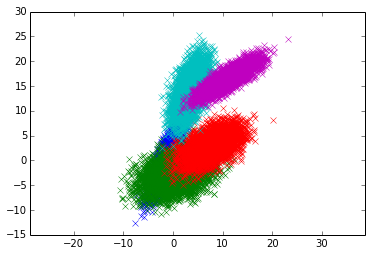

In [103]:
### do LDA computations by hand ###
#compute means of each class (empirical)

X, X_test, y, y_test = generateData(5, 5000, 1000)

means =  [np.mean(x, 1) for x in X_separated] #empirical mean of each
mean = np.array(np.mean(means, 0))

#compute within class scatter (covariances)
covariances = np.array([np.cov(x) for x in X_separated]) #within class covariance matrices
S_W = covariances.sum(axis=0) #S_w, the Within-class Scatter matrix (sum of covariance matrices of each class)

#compute between class scatter (means) - sum of outer products of deviations of the class means from universal mean
S_B = numGaussians*N*sum([np.outer((x - mean), (x - mean)) for x in means]) #Between-class Scatter, shape (2, 2) 

#To solve the generalized eigenvalue problem inv(S_W)*S_B*x = \lambda*x, must compute the eigendecomposition
#of invS_W * S_B. The top-most eigenvector (assoc. with greatest eigenvalue) is the direction of maximimum 
#discriminancy
invS_W = lin.inv(S_W)
Z = invS_W * S_B

#solve the eigenvalue problem, obtain the eigenvectors sorted by decreasing eigenvalue
[vals, vecs] = lin.eig(Z)

#annoying way to sort vecs by the vals...better way?
ev_list = zip(vals, vecs)
ev_list.sort(key=lambda tup:tup[0], reverse=True)
[vals, V] = zip(*ev_list)
V = np.array(V) #shape is (2, 2)

#project data onto the primary and secondary axes
proj_classes_first = np.array([np.dot(V[0], X_separated[i]) for i in range(numGaussians)]) #project onto top axis
proj_classes_second = np.array([np.dot(V[1], X_separated[i]) for i in range(numGaussians)]) #project onto next axis


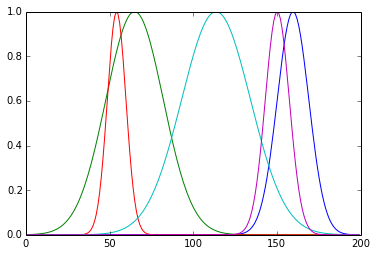

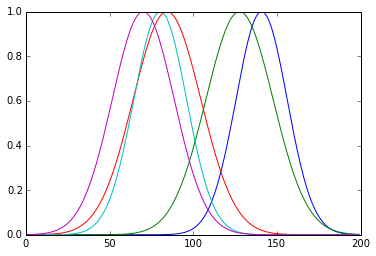

In [104]:
### visually inspect discriminating capability of axes found by LDA - can be skipped###
#plot distributions projected onto the first axis found by LDA
def gaussian(x, mu, sig):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

y_1min = min([min(x) for x in proj_classes_first])
y_1max = max([max(x) for x in proj_classes_first])
for projection in proj_classes_first:
    mu = np.mean(projection)
    sigma = np.std(projection)
    plt.plot(gaussian(np.linspace(y_1min, y_1max, 200), mu, sigma))
plt.show()

#plot projections onto second axis
y_2min = min([min(x) for x in proj_classes_second])
y_2max = max([max(x) for x in proj_classes_second])
for projection in proj_classes_second:
    mu = np.mean(projection)
    sigma = np.std(projection)
    plt.plot(gaussian(np.linspace(y_2min, y_2max, 200), mu, sigma))
plt.show()


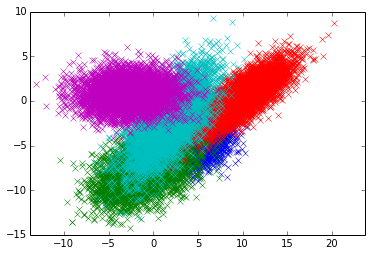

PCA: explained variance ratio: [ 0.70504721  0.29495279]
accuracy of built-in LDA on Test Data: 
0.827
Accuracy of K-nearest neighbor on raw test data


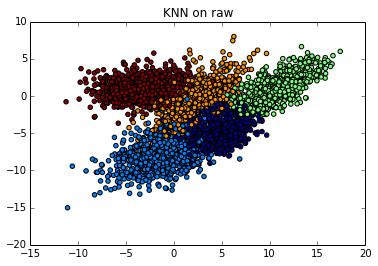

0.7962
running knearest neighbor on LDA-transformed data


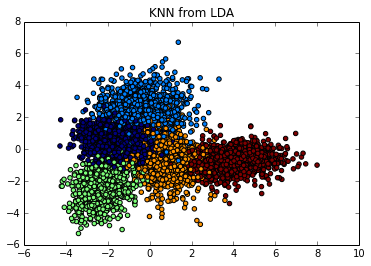

0.7922
running knearest neighbor on PCA-transformed data


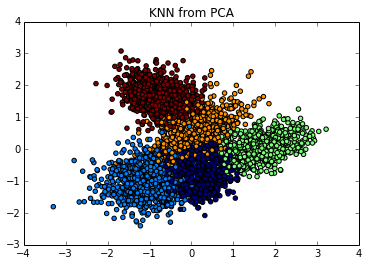

0.7958
running decision tree on LDA-transformed data


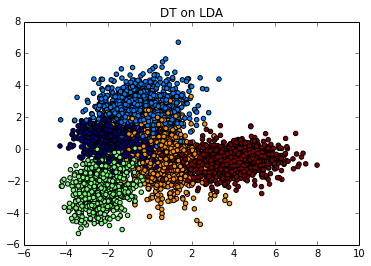

0.772
running decision tree on PCA-transformed data


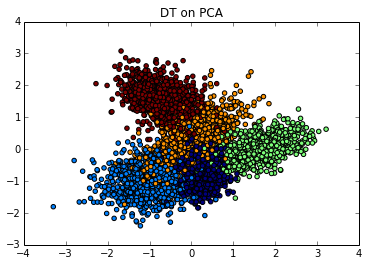

0.765


In [109]:
### Run classifiers on test data and see results. This cell can be run independently of any others ###
#   of course we could have just used the built-in LDA function from scikit (but that's no fun)
#   from sklearn import datasets

#   LDA seems to perform best when the clusters overlap and their means are mutually distant. If the means
#   are too close and the distributions overlap, then KNN seems to perform better
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree

#generate some data, or if you'd like to visually inspect it, run the above cells first
X, X_test, y, y_test = generateData(5, 5000, 1000)

# print X.shape
# print X_test.shape
# print y.shape
# print y_test.shape

target_names = [i for i in range(numGaussians)]

pca = PCA(n_components=2, whiten=True)
X_pca = pca.fit(X).transform(X)
X_pca_test = pca.transform(X_test)
print 'PCA: explained variance ratio: ' + str(pca.explained_variance_ratio_)
#print '    and avg likelihood: ' + str(pca.score(X))

lda = LinearDiscriminantAnalysis(n_components=(numGaussians - 1))
X_lda = lda.fit(X, y).transform(X)
X_lda_test = lda.transform(X_test)
lda.predict(X_test)
print 'accuracy of built-in LDA on Test Data: '
print str(lda.score(X_test, y_test))


# classifiers
neigh = KNeighborsClassifier(n_neighbors=2)
print 'Accuracy of K-nearest neighbor on raw test data'
neigh.fit(X, y) 
Z = neigh.predict(X_test)
plt.scatter(X_test[:, 0], X_test[:, 1], c=Z)
plt.title('KNN on raw')
plt.show()
print neigh.score(X_test, y_test)

neigh = KNeighborsClassifier(n_neighbors=2)
print 'running knearest neighbor on LDA-transformed data'
neigh.fit(X_lda, y) 
Z = neigh.predict(X_lda_test)
plt.scatter(X_lda_test[:, 0], X_lda_test[:, 1], c=Z)
plt.title('KNN from LDA')
plt.show()
print neigh.score(X_lda_test, y_test)

neigh = KNeighborsClassifier(n_neighbors=2)
print 'running knearest neighbor on PCA-transformed data'
neigh.fit(X_pca, y) 
Z = neigh.predict(X_pca_test)
plt.scatter(X_pca_test[:, 0], X_pca_test[:, 1], c=Z)
plt.title('KNN from PCA')
plt.show()
print neigh.score(X_pca_test, y_test)

print 'running decision tree on LDA-transformed data'
tr33 = tree.DecisionTreeClassifier()
tr33 = tr33.fit(X_lda, y)
Z = tr33.predict(X_lda_test)
plt.scatter(X_lda_test[:, 0], X_lda_test[:, 1], c=Z)
plt.title('DT on LDA')
plt.show()
print tr33.score(X_lda_test, y_test)

print 'running decision tree on PCA-transformed data'
tr33 = tree.DecisionTreeClassifier()
tr33 = tr33.fit(X_pca, y)
Z = tr33.predict(X_pca_test)
plt.scatter(X_pca_test[:, 0], X_pca_test[:, 1], c=Z)
plt.title('DT on PCA')
plt.show()
print tr33.score(X_pca_test, y_test)

In [107]:
#### XRMB DATA - load and preprocess ####
#XRMB contains two views of speech: articulatory and acoustic, each predictive of the labels, which are phonemes
scaler = preprocessing.StandardScaler()
mfcc_features = scaler.fit_transform(preprocessing.normalize(np.transpose(JW11['MFCC'])))
articulatory_features = scaler.fit_transform(preprocessing.normalize(np.transpose(JW11['X']).astype(float)))
phone_labels = np.transpose(JW11['P'][0])

n_samples = mfcc_features.shape[0]
n_mfcc_features = mfcc_features.shape[1]
n_articulatory_features = articulatory_features.shape[1]

permutation = np.random.permutation(n_samples)
X1 = np.asarray([mfcc_features[i] for i in permutation])
X2 = np.asarray([articulatory_features[i] for i in permutation])
#Y = np.asarray([binarized_labels[i] for i in permutation])
Phones = np.asarray([phone_labels[i] for i in permutation])

train, dev, test = 25948, 40948, 50948 

#two views of data, X and Y
X1_tr = X1[0:train, :]
X1_dev = X1[train:dev, :]
X1_test = X1[dev:test, :]
X2_tr = X2[0:train, :]
X2_dev = X2[train:dev, :]
X2_test = X2[dev:test, :]
#Y_tr = Y[0:train, :]
#Y_dev = Y[train:dev, :]
#Y_test = Y[dev:test, :]

#labels
Phones_tr = Phones[0:train]
Phones_dev = Phones[train:dev]
Phones_test = Phones[dev:test]

#"core" features of the time series data
baseline_acoustic_tr = X1_tr[:, 118:157]
baseline_acoustic_dev = X1_dev[:, 118:157]
baseline_acoustic_test = X1_test[:, 118:157]

In [14]:
#apply dimensionality reduction to XRMB data
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA

n_comps = 40
#LDA on View 1
lda = LinearDiscriminantAnalysis(n_components=n_comps)
X_lda1 = lda.fit(X1_tr, Phones_tr).transform(X1_tr)
X1_lda_test = lda.transform(X1_test)
lda.predict(X1_test)
print 'score of LDA on view 1: ' + str(lda.score(X1_test, Phones_test))

#LDA on View 2
lda2 = LinearDiscriminantAnalysis(n_components=n_comps)
X_lda2 = lda2.fit(X2_tr, Phones_tr).transform(X2_tr)
lda2.predict(X2_test)
print 'score of LDA on view 2: ' + str(lda2.score(X2_test, Phones_test))

#PCA on View 1
pca = PCA(n_components=n_comps, whiten=True)
X_pca1 = pca.fit(X1_tr).transform(X1_tr)
X1_pca_test = pca.transform(X1_test)
print 'pca view 1 explained variance ratio: ' + str(pca.explained_variance_ratio_)
print ' and avg likelihood: ' + str(pca.score(X1_tr))
    
#PCA on View 2
pca = PCA(n_components=n_comps, whiten=True)
X_pca2 = pca.fit(X2_tr).transform(X2_tr)
print 'pca view 2 explained variance ratio: ' + str(pca.explained_variance_ratio_)
print ' and avg likelihood: ' + str(pca.score(X2_tr))

#apply both PCA and LDA dimensionality reduction techniqes to the data set and then attempt
#classification by KNN, for instance, to see which reduction technique is most effective

#baseline KNN for view 1
neigh = KNeighborsClassifier(n_neighbors=2)
print 'running knearest neighbor on raw data'
neigh.fit(X1_tr, Phones_tr) 
neigh.predict(X1_test)
print neigh.score(X1_test, Phones_test)

#KNN on LDA transformed data; view 1
neigh2 = KNeighborsClassifier(n_neighbors=2)
print 'running knearest neighbor on LDA View 1'
neigh.fit(X_lda1, Phones_tr) 
neigh.predict(X1_lda_test)
print neigh.score(X1_lda_test, Phones_test)

#KNN on PCA transformed data; view 1
neigh2 = KNeighborsClassifier(n_neighbors=2)
print 'running knearest neighbor on PCA View 1'
neigh.fit(X_pca1, Phones_tr) 
neigh.predict(X1_pca_test)
print neigh.score(X1_pca_test, Phones_test)


score of LDA on view 1: 0.5198
score of LDA on view 2: 0.5804
pca view 1 explained variance ratio: [ 0.0901229   0.06777988  0.06031566  0.05208485  0.04815885  0.04424586
  0.04059334  0.03766653  0.03589603  0.03291267  0.0307196   0.02789757
  0.02663582  0.02363518  0.02145113  0.02089129  0.02036688  0.01931787
  0.01840717  0.01728466  0.0158446   0.01377826  0.0129433   0.01200754
  0.01164998  0.01147664  0.01050254  0.01021653  0.00889549  0.00832286
  0.00740371  0.00724193  0.00613322  0.00550447  0.0052491   0.00480796
  0.00455636  0.00440542  0.00406726  0.00360614]
 and avg likelihood: -161.243057418
pca view 2 explained variance ratio: [  3.11045032e-01   1.83471493e-01   1.41280977e-01   1.01883731e-01
   6.64548783e-02   4.90957778e-02   3.73799225e-02   2.60076135e-02
   1.72954026e-02   1.25367358e-02   9.03381256e-03   7.48737775e-03
   6.67111199e-03   5.30885977e-03   4.42738079e-03   4.06874283e-03
   3.41951357e-03   2.08528465e-03   1.94711067e-03   1.43525380